## 1-Exploring Data

In [1]:
#Libraries used:

#N-dimensional array object, linear algebra, random numbers...
import numpy as np 

#data structures and data analysis tools
import pandas as pd

#interactive plots
import matplotlib.pyplot as plt 

#handling on-disk datasets as if they were NumPy arrays
import h5py 

#Operating system dependent functionality
import os

#regular expression
import re 

#pathnames matching
from glob import glob

#Interactive Python for images
from IPython.display import Image
from IPython.display import clear_output

#openCV for image processing
import cv2

#Shallow and deep copy operations
import copy

import time


D:\Anaconda-Jupyter\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
#Display Dataframe
all_cases_df = pd.read_table('C:/Users/victory/Desktop/MIAS/mammogram_info.csv', 
                             delimiter=' ')
all_cases_df.head(25) 

1st column: MIAS database reference number.

2nd column: Character of background tissue:

F Fatty

G Fatty-glandular

D Dense-glandular


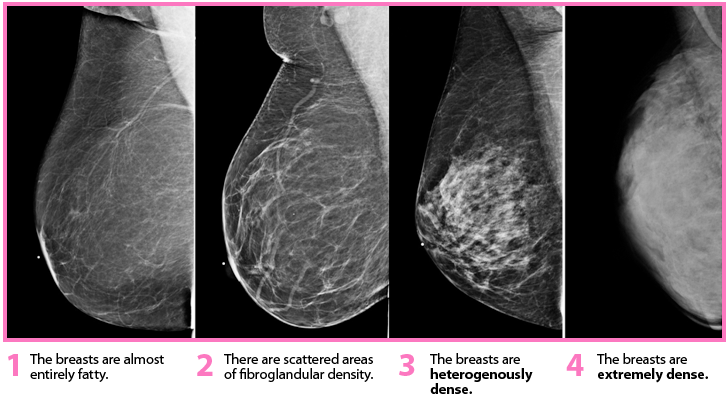

In [14]:
Image(filename='C:/Users/victory/Desktop/MIAS Help/B.PNG')

3rd column: Class of abnormality present:

CALC Calcification

CIRC Well-defined/circumscribed masses

SPIC Spiculated masses

MISC Other, ill-defined masses

ARCH Architectural distortion

ASYM Asymmetry

NORM Normal


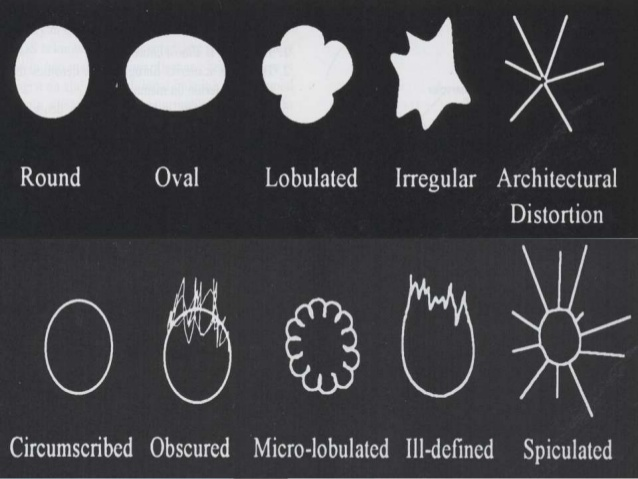

In [15]:
Image(filename='C:/Users/victory/Desktop/MIAS Help/B2.JPG')

4th column: Severity of abnormality;

B Benign

M Malignant

5th, 6th columns: x,y image-coordinates of centre of abnormality.

7th column: Approximate radius (in pixels) of a circle enclosing the abnormality.

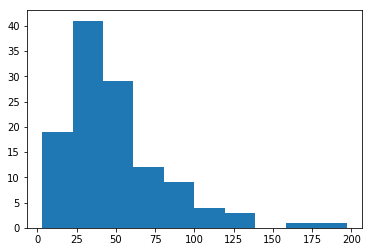

In [16]:
# the sizes of radii
radii = all_cases_df.Rad
radii.dropna(inplace=True)
plt.hist(radii)
plt.show()

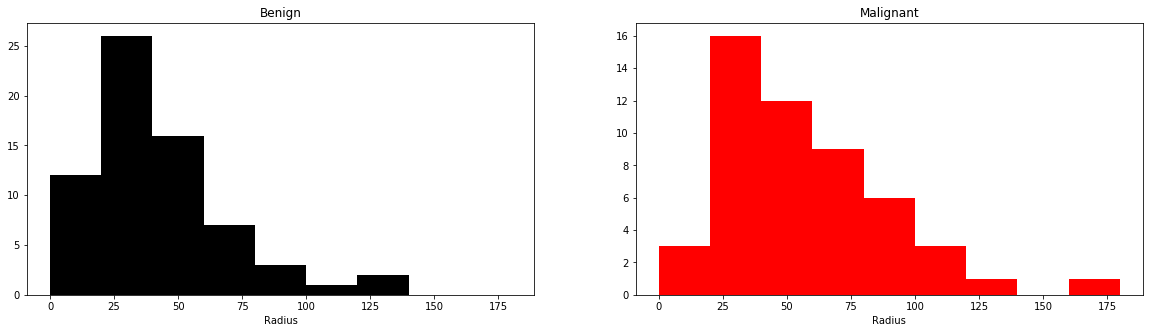

In [18]:
#radii by severity
sev_radii = all_cases_df.loc[:,['Rad','Sever']]
sev_radii.dropna(axis=0, how='any', inplace=True)
benign = sev_radii[sev_radii.Sever == 'B']
malignant = sev_radii[sev_radii.Sever == 'M']
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(benign.Rad, color="black", bins=range(0,200,20))
ax[0].set_xlabel("Radius")
ax[0].set_title("Benign")
ax[1].hist(malignant.Rad, color="red",  bins=range(0,200,20))
ax[1].set_title("Malignant")
ax[1].set_xlabel("Radius")
plt.show()

In [19]:
#import PGM files and return a numpy array
def read_pgm(filename, byteorder='>'):
   
    with open(filename, 'rb') as f:
       buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
        
    image = np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
    
    image_id = int(re.findall('([\d]+)\.', filename)[0])
    
    return image

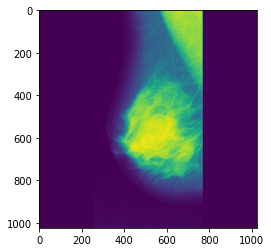

In [20]:
plt.imshow(read_pgm(glob('C:/Users/victory/Desktop/MIAS/*.pgm')[0]))

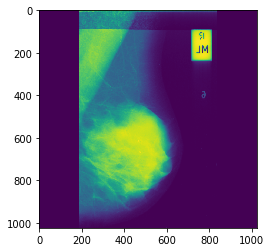

In [21]:
plt.imshow(read_pgm(glob('C:/Users/victory/Desktop/MIAS/*.pgm')[1]))

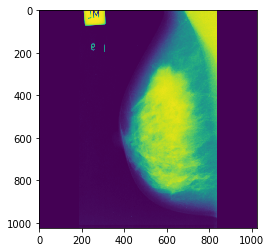

In [22]:
plt.imshow(read_pgm(glob('C:/Users/victory/Desktop/MIAS/*.pgm')[2]))

In [ ]:
# Clean up the data.
# drop images with multiple abnormalities 
# keep one row per image
all_cases_df.drop_duplicates(subset=['Reference'], 
                             keep='first', inplace=True)

# reindex the image
all_cases_df.reset_index(inplace=True)
all_cases_df.shape

In [29]:
# percentages by class
all_cases_df['Class'].value_counts(normalize=True)

NORM    0.642857
CALC    0.077640
CIRC    0.071429
SPIC    0.059006
ARCH    0.059006
ASYM    0.046584
MISC    0.043478
Name: Class, dtype: float64

In [30]:
# info on the size of the abnormalities
print("Mean abnormality radius:",np.mean(radii))
print("Median abnormality radius:",np.median(radii))
print("Min abnormality radius:",np.min(radii))
print("Max abnormality radius:",np.max(radii))

Mean abnormality radius: 48.84873949579832
Median abnormality radius: 41.0
Min abnormality radius: 3.0
Max abnormality radius: 197.0


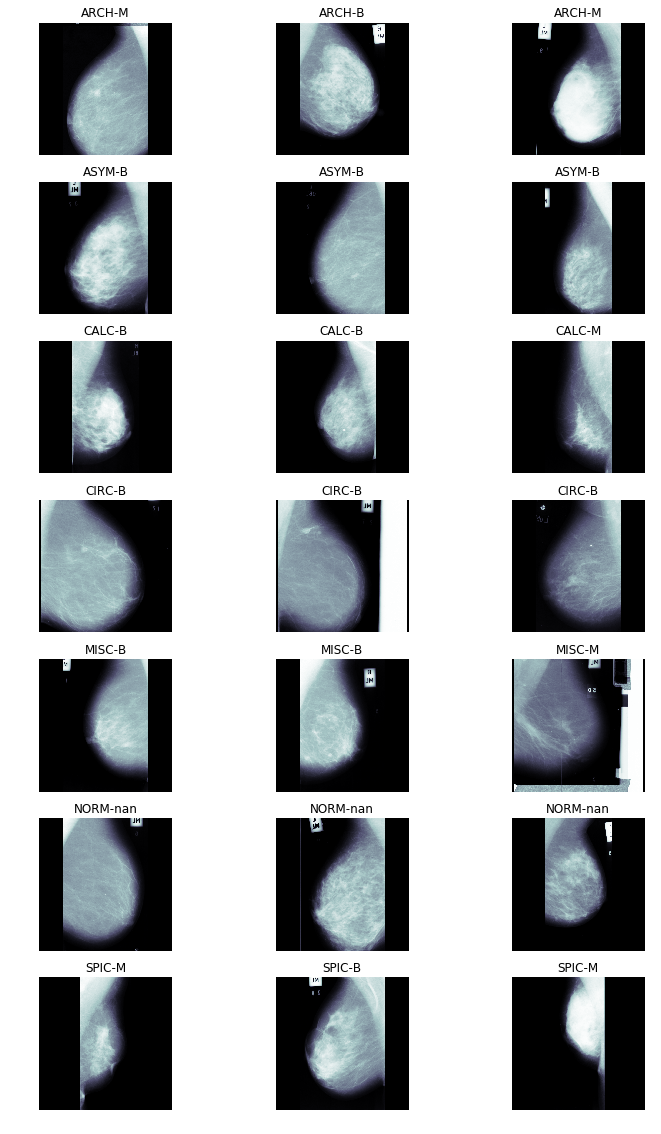

In [14]:
sample_count = 3
fig, m_axs = plt.subplots(len(all_cases_df['Class'].value_counts()),
                          3, figsize = (12, 20))
for c_axs, (c_cat, c_df) in zip(m_axs, all_cases_df.groupby('Class')):
    for c_ax, (_, c_row) in zip(c_axs, c_df.sample(sample_count).iterrows()):
        c_ax.imshow(read_pgm('C:/Users/victory/Desktop/MIAS/' + 
                             c_row['Reference'] + '.pgm'), cmap = 'bone')
        c_ax.axis('off')
        c_ax.set_title('{Class}-{Sever}'.format(**c_row))

## 2-PreProcessing

In [31]:
#create the histogramo the image
def get_hists(image, b):
    hist, bins = np.histogram(img.flatten(), bins=b, range=[0,255])
    cdf = hist.cumsum() #cumulative distribution function as ndarray
    cdf_normalized = cdf *hist.max()/ cdf.max() #normalization step
    
    return [hist, cdf_normalized]

In [32]:
#plot the histogram and the image 
def plot(img, img_hists):
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(122)
    plt.plot(img_hists[1], color = 'b')
    plt.plot(img_hists[0], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
    plt.subplots_adjust(top=0.92, bottom=0.08,
                        left=0.10, right=0.95,
                        hspace=0.25, wspace=0.35)

In [ ]:
#CLAHE algorithm
def threshold(img_list, factor = 0.7, select_files = []):
    images_t = []
    
    def internal(data):
        thresholded = cv2.threshold(data['clahe_img'],
                                    np.median(data['clahe_img']) * factor, 255,
                                    cv2.THRESH_BINARY)[1]     # the binary image
            
        _, l, s, _ = cv2.connectedComponentsWithStats(thresholded)
        images_t.append( {'filename': data['filename'],
                          'clahe_img': data['clahe_img'],
                          'thresh_img': thresholded,
                          'factor': factor,
                          'labels':l,  # contiguous regions in mammogram
                          'count':s[:, -1]  # count of pixels 
                         })
    
    if not select_files:
        print ('Processing all files')
        for i, data in enumerate(img_list):
            internal(data)
            
    else:
        print('Processing select files {}'.format(select_files))
        for i, data in enumerate(img_list):
            if data['filename'] in select_files:
                internal(data)
                
    return images_t

In [34]:
#add the mask
def mask(image, labels, region):
    labels = copy.deepcopy(labels)  # create a full, unique copy of labels
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if labels[row, col] != region:
                labels[row, col] = 0  # mask the artifact
            else:
                labels[row, col] = 1  # retain the breast
    return labels

In [35]:
#remove all unnecesary artifacts, labels, writings...
def clean_art(images_thresh):
    revist = []
    for i, data in enumerate(images_thresh):
        fn, c_img, t_img = data['filename'], data['clahe_img'], data['thresh_img']
        print( 'Processing File: {}'.format(fn))

        plt.subplot(121)
        plt.imshow(c_img, cmap='gray')
        plt.title('Original')
        plt.subplot(122)
        plt.imshow(t_img, cmap='gray')
        plt.title('Binary Threshold')
        plt.show()
        plt.pause(0.1)
        
        top_regions = np.argpartition(data['count'], -2)[-2:]
        print(len(top_regions))
        top_counts = data['count'][top_regions]
        print ('Top region pixel counts: {}'.format(top_counts))
        my_mask = mask( t_img, data['labels'], region=top_regions[1])
        image = c_img * my_mask
        
        image = np.array(image, dtype = np.uint8)
        
        plt.imshow(image, cmap='gray')
        plt.title(fn)
        plt.show()
        plt.pause(0.1)
                
        input4 = input("Save post processed image (Y/N): ").lower()
        if input4 == 'y':
            save(fn, image)
        
        clear_output()
    return revist

In [36]:
#save the pre-processed images

#add the pre-processed images directory
SAVE_DIR = 'C:/Users/victory/Desktop/MIAS/Pre-processed' 

def save(fn, img, location=SAVE_DIR):
    print( 'Saving: {}'.format(location + fn))
    cv2.imwrite(location + fn, img)
    time.sleep(2)

Processing File: mdb006.pgm


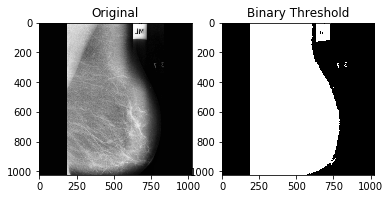

2
Top region pixel counts: [509627 526422]


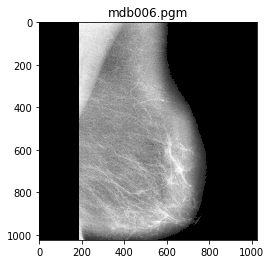

In [ ]:
#applying all the previous methods on the dataset

filenames = [ filename for filename in os.listdir('C:/Users/victory/Desktop/MIAS') 
             if filename.endswith('.pgm')] #raw images directory

clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
os.chdir('C:/Users/victory/Desktop/MIAS/') #raw imges directory
for filename in filenames:
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    clahe_images.append({'filename': filename, 'clahe_img': clahe.apply(img)})
os.chdir(os.getcwd()) #current directory

images_thresh = threshold(clahe_images)
print (len(images_thresh))

remaining = clean_art(images_thresh)
remaining_fn = [item['filename'] for item in remaining]